In [1]:
import pickle, glob
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib import colormaps 
import matplotlib.ticker as ticker

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from botorch.utils.transforms import normalize
from activephasemap.utils.settings import AutoPhaseMapDataSet

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [12]:
DATA_DIR = "./phasemap/"
design_space_bounds = [(0.0, 87.0), (0.0,11.0)]

# Construct data on a grid
grid_spectra = np.load(DATA_DIR+"grid/grid_spectra.npy")
grid_spectra = grid_spectra/grid_spectra[:,0][:,None]
grid_comps = np.load(DATA_DIR+"grid/grid_comps.npy")
t = np.linspace(0,1, grid_spectra.shape[1])

data = AutoPhaseMapDataSet(grid_comps, 
                           t, 
                           grid_spectra, 
                           )
data.generate(process=None)

In [3]:
def prettify_axis(ax):
    ax.set_xlabel('Z2 concentration (mM)')
    ax.set_ylabel('Time delay (min)') 
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    vol_labels = [item.get_text() for item in ax.get_xticklabels()]
    z2_vol_to_conc = lambda v : (0.3*v)/(280.0-v)
    conc_labels = []
    for l in vol_labels:
        conc_labels.append("%.2f"%z2_vol_to_conc(float(l)))
    ax.set_xticklabels(conc_labels)
    return ax

### Plot BIC trace to find preferred clusters

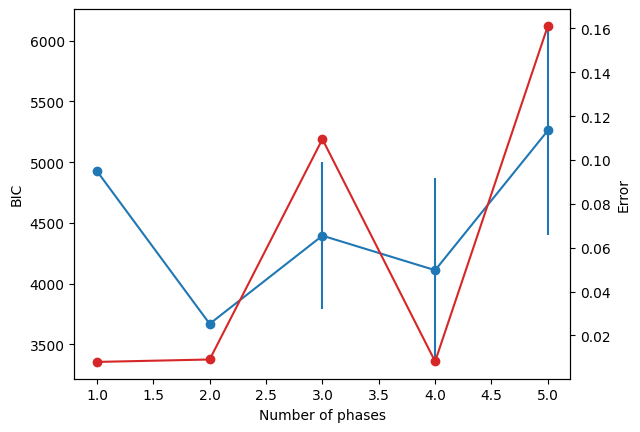

In [92]:
sweep_n_clusters = np.arange(1,len(glob.glob(DATA_DIR+"bic_*.npy"))+1)
bic_mean_std_error = np.zeros((len(sweep_n_clusters), 3))

for i in sweep_n_clusters:
    bic = np.load(DATA_DIR+"bic_%d.npy"%i)
    with open(DATA_DIR+'result_%d.pkl'%i, 'rb') as f:
        result = pickle.load(f)
    bic_mean_std_error[i-1,:] = [bic.mean(), bic.std(), result["error"]]
fig, ax = plt.subplots()
ax.errorbar(sweep_n_clusters, bic_mean_std_error[:,0], bic_mean_std_error[:,1], fmt="-o", color="tab:blue")
ax2 = ax.twinx()
ax2.plot(sweep_n_clusters, bic_mean_std_error[:,2], "-o", color="tab:red")
ax.set_xlabel("Number of phases")
ax.set_ylabel("BIC")
ax2.set_ylabel("Error")
plt.show()

In [24]:
MIN_BIC_N_CLUSTERS = 4
with open(DATA_DIR+'result_%d.pkl'%MIN_BIC_N_CLUSTERS, 'rb') as f:
    result = pickle.load(f)
grid_comps.shape, grid_spectra.shape, result["delta_n"].shape

((625, 2), (625, 100), (625,))

### Plot phasemaps based on GP fitting

In [25]:
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

color_blindf = ["#1F77B4", "#AEC7E8", "#FF7F0E", "#FFBB78", 
                "#2CA02C", "#98DF8A", "#D62728", "#FF9896", 
                "#9467BD", "#C5B0D5", "#8C564B",  "#C49C94", 
                "#E377C2", "#F7B6D2", "#7F7F7F", "#C7C7C7", 
                "#BCBD22", "#DBDB8D", "#17BECF", "#9EDAE5"
                ]

In [26]:
train_x = torch.Tensor(data.C)
train_y = torch.Tensor(result["delta_n"]).long().squeeze()

n_grid_points = 30
test_d1 = np.linspace(data.C[:,0].min(), data.C[:,0].max(), n_grid_points)
test_d2 = np.linspace(data.C[:,1].min(), data.C[:,1].max(), n_grid_points)
test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)

class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

# Find optimal model hyperparameters
training_iter = 200
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 20 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    pred_means = test_dist.loc

pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

Iter 1/200 - Loss: 15.893   lengthscale: 0.693   noise: 0.693
Iter 21/200 - Loss: 8.318   lengthscale: 2.047   noise: 0.969
Iter 41/200 - Loss: 7.215   lengthscale: 3.125   noise: 0.427
Iter 61/200 - Loss: 7.000   lengthscale: 3.532   noise: 0.150
Iter 81/200 - Loss: 6.932   lengthscale: 3.649   noise: 0.075
Iter 101/200 - Loss: 6.893   lengthscale: 3.677   noise: 0.049
Iter 121/200 - Loss: 6.865   lengthscale: 3.684   noise: 0.036
Iter 141/200 - Loss: 6.844   lengthscale: 3.686   noise: 0.028
Iter 161/200 - Loss: 6.827   lengthscale: 3.684   noise: 0.023
Iter 181/200 - Loss: 6.813   lengthscale: 3.681   noise: 0.019


/Users/pozzolabadmin/Documents/codebase/envs/activephasemap/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_5823/1487545943.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


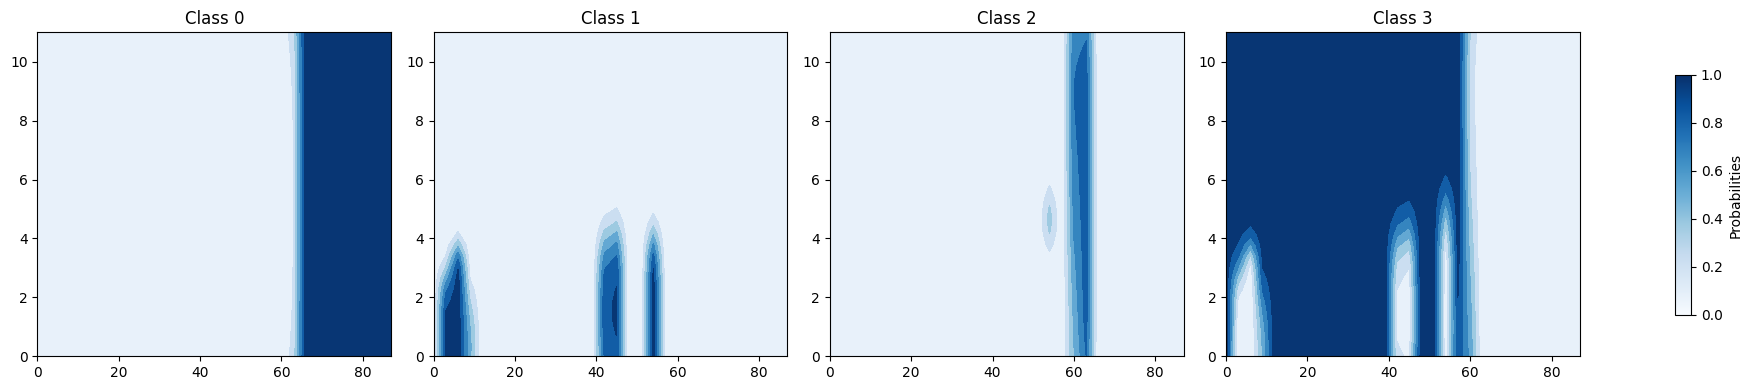

In [27]:
cmap = colormaps["Blues"]
norm = Normalize(vmin=0, vmax = 1)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, axs = plt.subplots(1, 4, figsize = (4*4, 4*1))
[ax.remove() for ax in axs[MIN_BIC_N_CLUSTERS:]]
axs = axs.flatten()
# fig.subplots_adjust(wspace=0.2)
for i in range(MIN_BIC_N_CLUSTERS):
    im = axs[i].contourf(test_x_mat.numpy(), 
                         test_y_mat.numpy(), 
                         probabilities[i].numpy().reshape((n_grid_points,n_grid_points)),
                         cmap=cmap, norm=norm
                         )
    axs[i].set_title("Class " + str(i))
cax = plt.axes([1.05, 0.2, 0.01, 0.6])        
cbar = fig.colorbar(mappable, cax=cax)
cbar.ax.set_ylabel('Probabilities')
plt.tight_layout()
plt.show()

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_5823/1474876256.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(conc_labels)


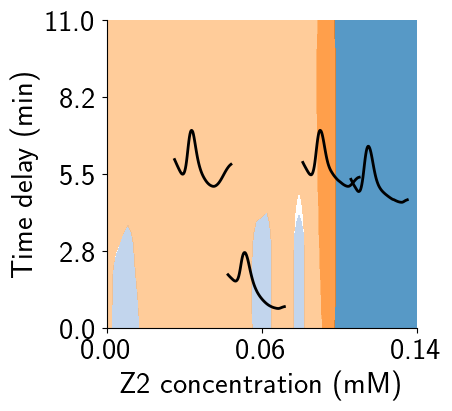

In [28]:
with plt.style.context(pyplot_style):
    cmap = colormaps["tab10"]
    norm = Normalize(vmin=0, vmax = MIN_BIC_N_CLUSTERS)
    fig, ax = plt.subplots(figsize=(4, 4))
    min_prob = 0.5
    for k in range(MIN_BIC_N_CLUSTERS):
        flags = probabilities[k]>min_prob
        comps_k_mean = np.median(test_x[flags,:], axis=0)
        norm_ci = (comps_k_mean-data.C.min(axis=0))/((data.C.max(axis=0)-data.C.min(axis=0)))
        loc_ax = ax.transLimits.transform(norm_ci)
        ins_ax = ax.inset_axes([loc_ax[0]-0.1,loc_ax[1]-0.1,0.2,0.2])
        ins_ax.plot(data.t, result["templates"][k], color="k", lw=2.0)
        ins_ax.axis("off")

    for k in range(MIN_BIC_N_CLUSTERS):
        ax.contourf(test_x_mat.numpy(),
                    test_y_mat.numpy(),
                    probabilities[k].numpy().reshape((n_grid_points,n_grid_points)),
                    levels=[min_prob, 1.0],
                    colors=color_blindf[k],
                    alpha=0.75
                    )
    prettify_axis(ax)
    plt.show()

### Look at clustered spectra

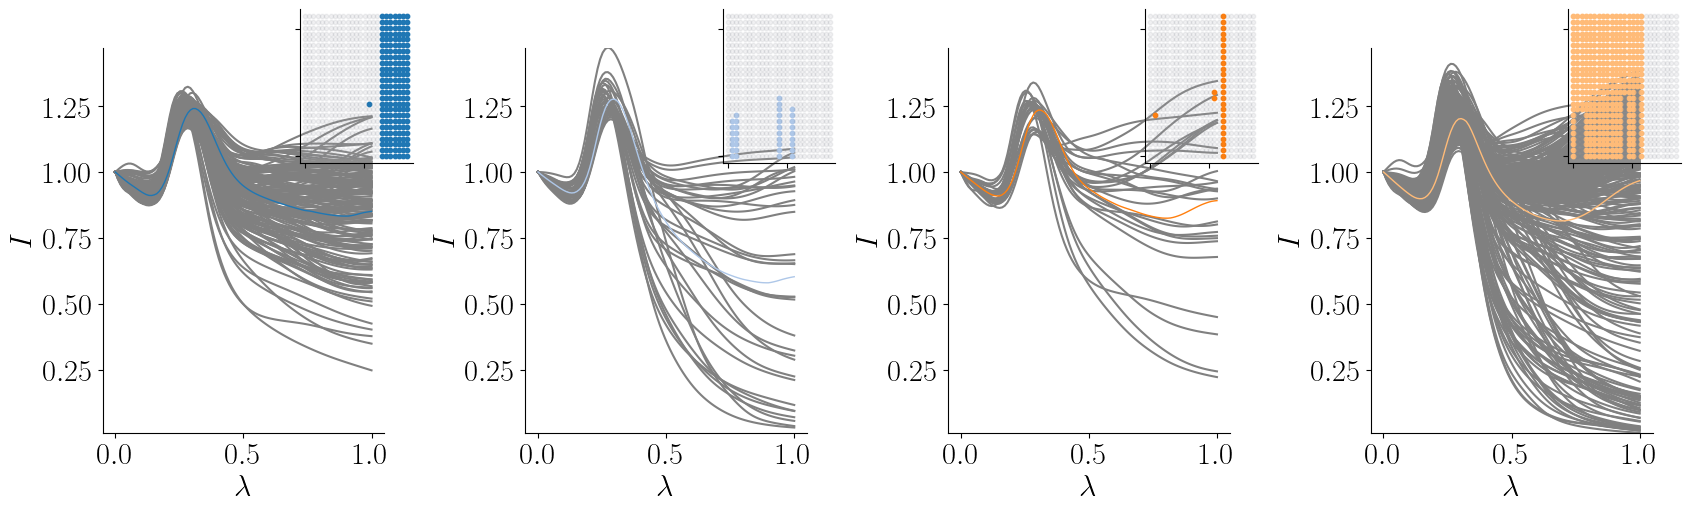

In [29]:
from autophasemap import plot_clusters 

with plt.style.context(pyplot_style):
    nrows, ncols = 1, 4
    fig, axs = plt.subplots(nrows, ncols, figsize = (5*ncols, 5*nrows))
    axs = axs.flatten()
    [ax.remove() for ax in axs[MIN_BIC_N_CLUSTERS:]]
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    plot_clusters(axs, data, result, mode="input", data_type="uvvis")
    plt.show()


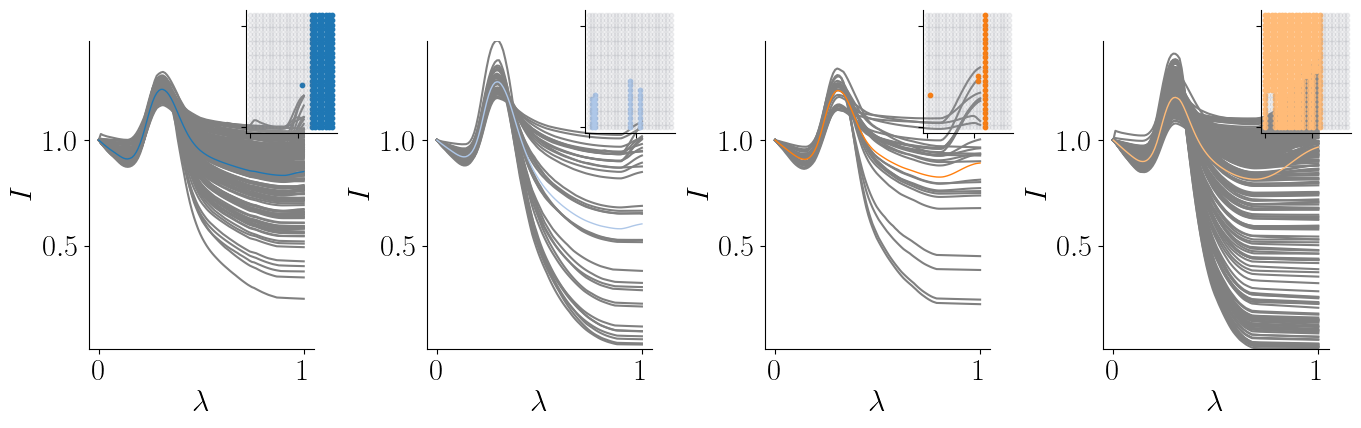

In [30]:
with plt.style.context(pyplot_style):
    nrows, ncols = 1, 4
    fig, axs = plt.subplots(nrows, ncols, figsize = (4*ncols, 4*nrows))
    axs = axs.flatten()
    [ax.remove() for ax in axs[MIN_BIC_N_CLUSTERS:]]
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    plot_clusters(axs, data, result, mode="aligned", data_type="uvvis")
    plt.show()

## Inspect clustered data at random

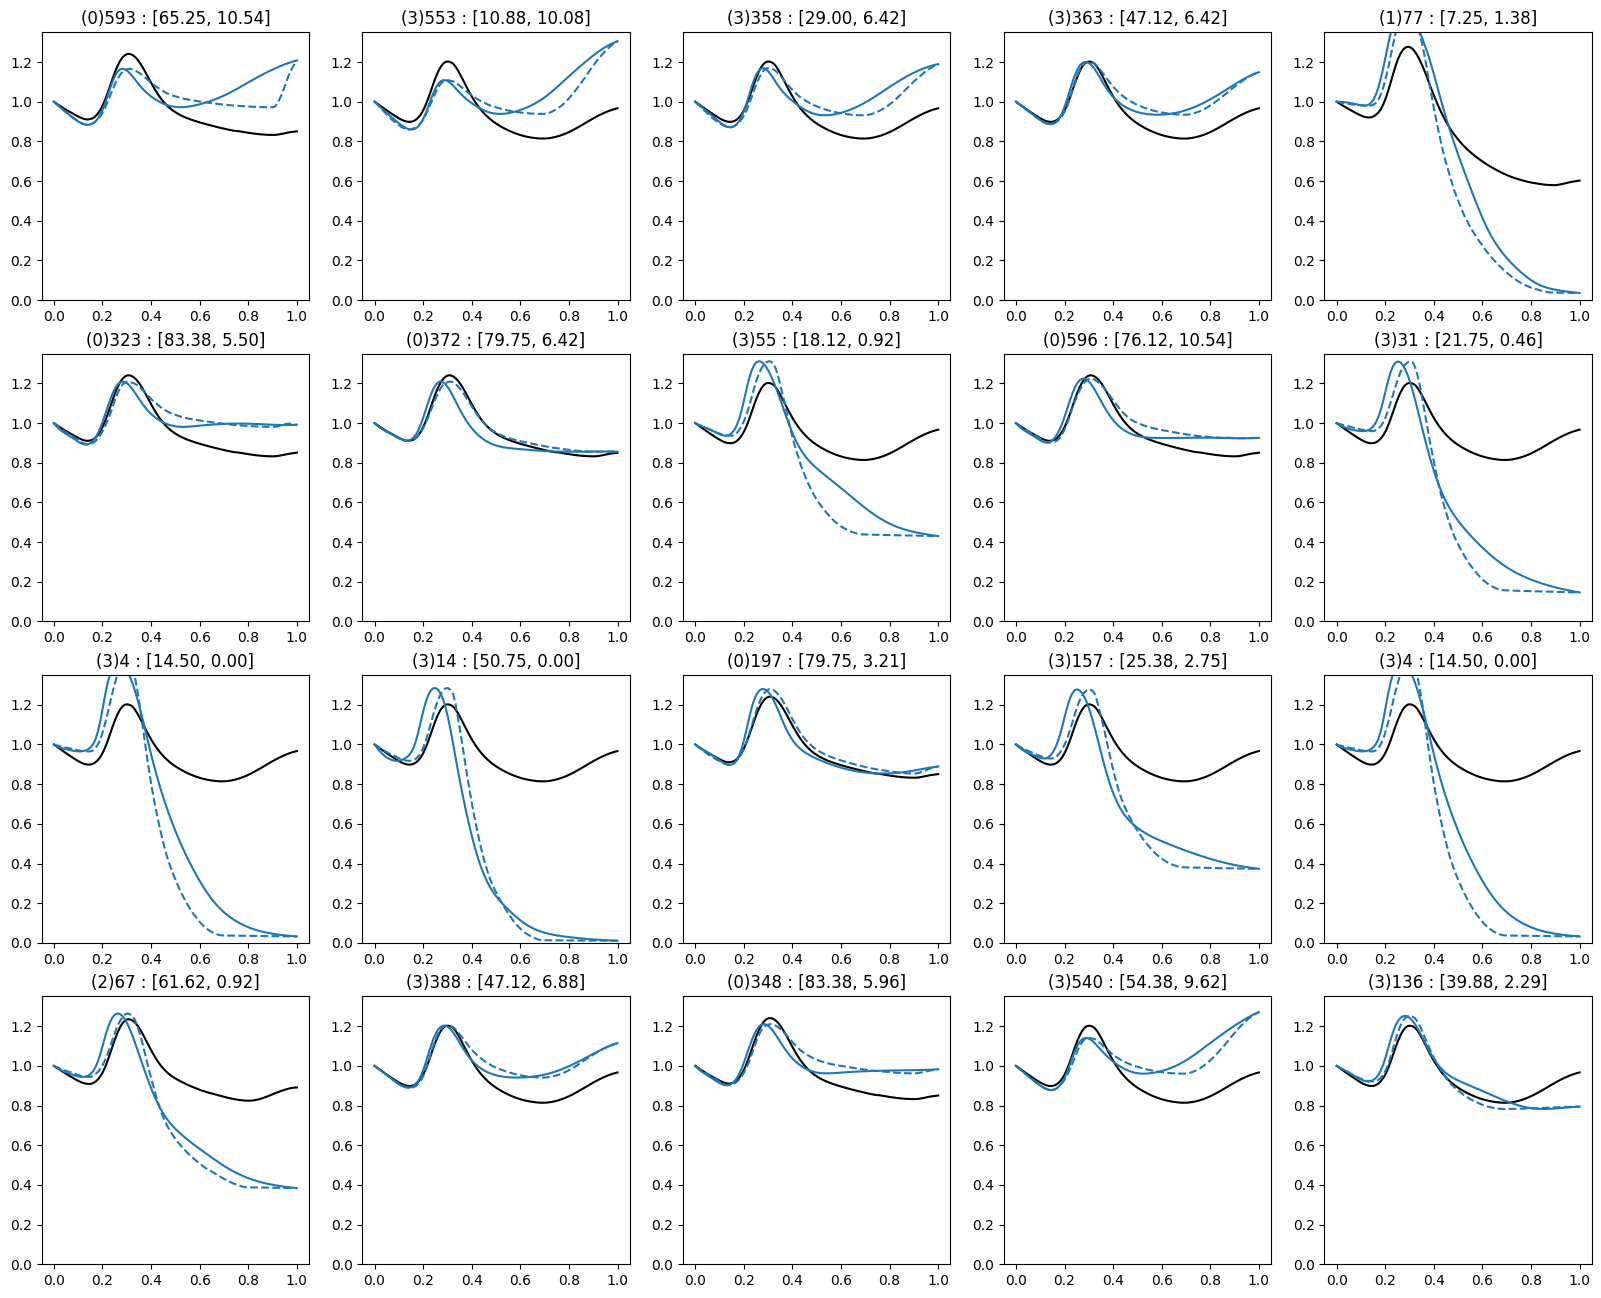

In [60]:
rids = np.random.randint(data.N, size=20)
fig, axs = plt.subplots(4,5, figsize=(5*4, 4*4))
for i, ax in enumerate(axs.flatten()):
    k = result["delta_n"][rids[i]]
    ax.plot(data.t, result["templates"][k], color="k")
    ax.plot(data.t, data.F[rids[i]], color="tab:blue")
    ax.plot(data.t, result["fik_gam"][rids[i],k,:], color="tab:blue", ls="--")
    ax.set_ylim([0.0,1.35])
    ax.set_title("(%d) %d : [%.2f, %.2f]"%(k, rids[i], *data.C[rids[i], :]))
plt.show()

In [80]:
# test warping from DL-based solution
from funcshape.functions import Function, get_warping_function

f1_ = torch.from_numpy(result["templates"][1]).reshape(-1,1)
f2_ = torch.from_numpy(data.F[14]).reshape(-1,1)
tt = torch.from_numpy(data.t)
f1 = Function(tt, f1_)
f2 = Function(tt, f2_)
optim_kwargs = {"n_iters":50, 
                "n_basis":10, 
                "n_layers":10,
                "domain_type":"linear",
                "basis_type":"palais",
                "n_restarts":50,
                "lr":1e-1,
                "n_domain":data.n_domain,
                "eps":0.1,
                "verbose":0,
                }
warping, network, error = get_warping_function(f1, f2, **optim_kwargs) 

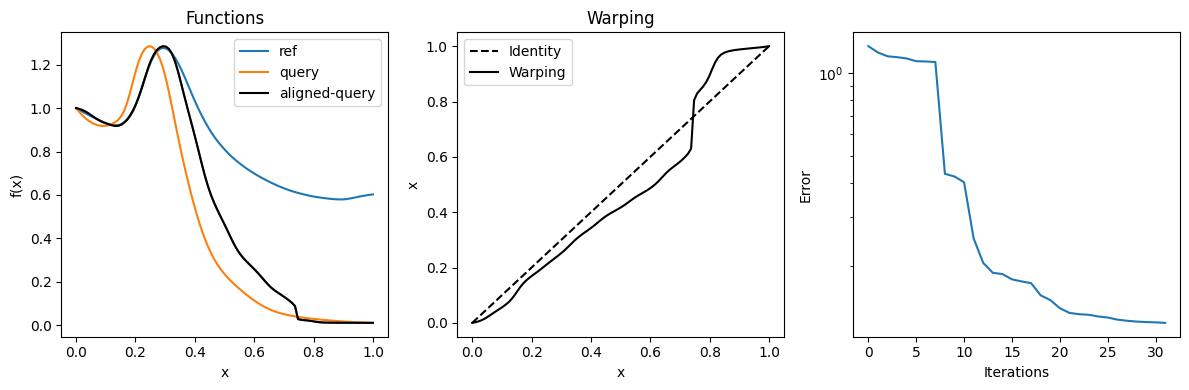

In [90]:
fig, axs =plt.subplots(1,3, figsize=(4*3, 4))

axs[0].plot(tt, f1_, label="ref")
axs[0].plot(tt, f2_, label="query")
f2_gamma_np = np.interp(warping.fx.cpu().numpy().squeeze(), 
                     data.t, 
                     f2_.cpu().numpy().squeeze()
                     )
f2_gamma_torch = f2(warping.fx).squeeze()
axs[0].plot(tt, f2_gamma_np, color="grey")
axs[0].plot(tt, f2_gamma_torch, color="k", label="aligned-query")
axs[0].legend()
axs[0].set(xlabel="x", ylabel="f(x)", title="Functions")

axs[1].plot(tt, tt, label="Identity", color="k", ls='--')
axs[1].plot(tt, warping.fx, color="k", label="Warping")
axs[1].set(xlabel="x", ylabel="x", title="Warping")
axs[1].legend()

axs[2].semilogy(error)
axs[2].set(xlabel="Iterations", ylabel="Error")

plt.tight_layout()
plt.show() 